In [ ]:
!pip install ultralytics opencv-python torch torchvision matplotlib seaborn pandas numpy pillow scikit-learn pyyaml qrcode flask

Using device: mps.
Project structure created.
Found 6 classes:
  paper: 594 images
  metal: 410 images
  cardboard: 403 images
  trash: 137 images
  glass: 501 images
  plastic: 482 images


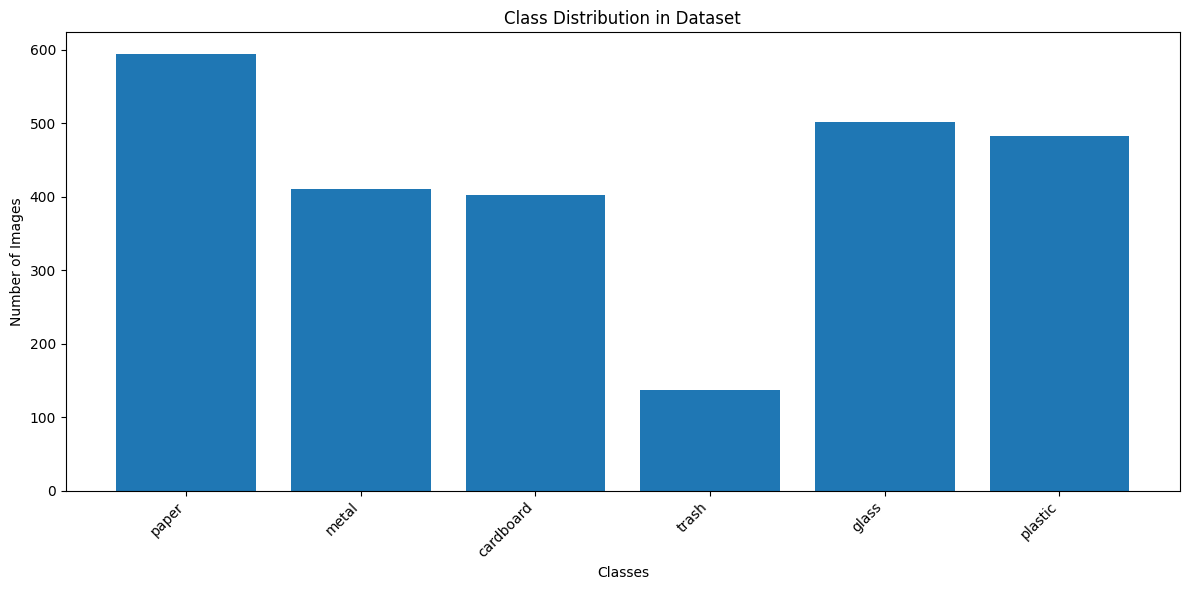

Processing 594 images from class 'paper'.
Processing 410 images from class 'metal'.
Processing 403 images from class 'cardboard'.
Processing 137 images from class 'trash'.
Processing 501 images from class 'glass'.
Processing 482 images from class 'plastic'.
Created labels for 2527 images.
Total files processed: 2527
Class mapping: {'paper': 0, 'metal': 1, 'cardboard': 2, 'trash': 3, 'glass': 4, 'plastic': 5}
Class paper: 475 train, 59 val, 60 test
Class metal: 328 train, 41 val, 41 test
Class cardboard: 322 train, 40 val, 41 test
Class trash: 109 train, 13 val, 15 test
Class glass: 400 train, 50 val, 51 test
Class plastic: 385 train, 48 val, 49 test

Dataset split:
Train: 2019 images
Validation: 251 images
Test: 257 images
Dataset preparation completed.
YOLO config created: garbage_classification_yolo/data/yolo_format/dataset.yaml.


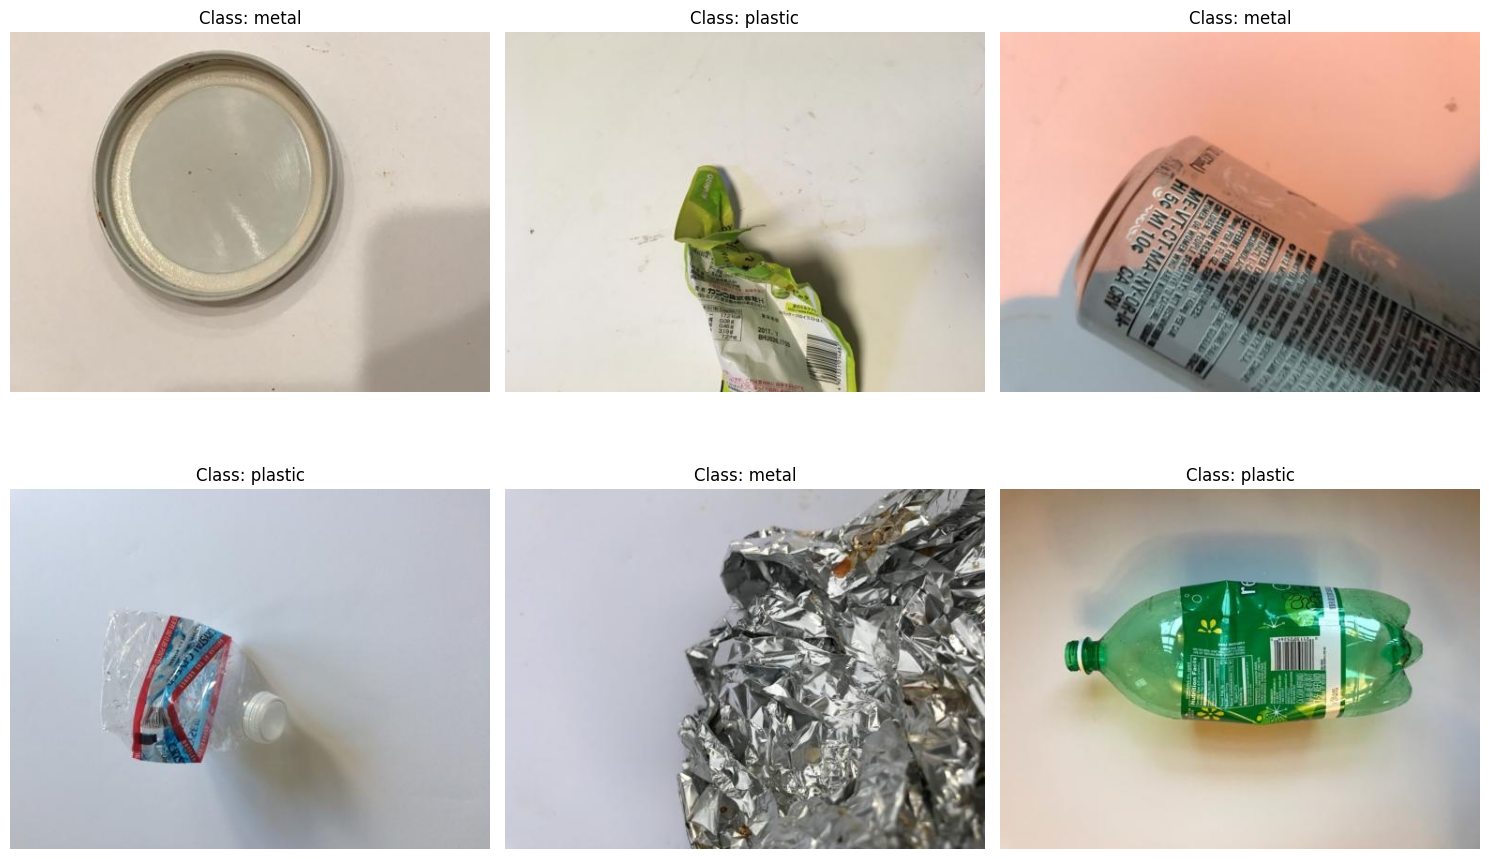


-------------------
Garbage Classifier System Options
-------------------
Existing trained model found.
Path: garbage_classification_yolo/models/garbage_classifier/weights/best.pt
Size: 5.95 MB
Created: Mon Jun 30 05:25:58 2025

Available options:
1. Train new model from scratch
2. Load existing model (if available)
3. Continue training existing model
4. Skip training
-------------------

Loading existing model...
Successfully loaded model: garbage_classification_yolo/models/garbage_classifier/weights/best.pt.

Model Information:
-------------------
Model loaded successfully.

-------------------
Model is ready for use.
Model location: 'garbage_classification_yolo/models/garbage_classifier/weights/best.pt'.
-------------------

Current model status:

Available Model Versions:
-------------------
last.pt - 5.95MB - Mon Jun 30 05:25:58 2025
epoch0.pt - 17.59MB - Sat Jun 28 22:10:02 2025
best.pt - 5.95MB - Mon Jun 30 05:25:58 2025
epoch10.pt - 17.60MB - Sat Jun 28 22:56:49 2025
epoch20.p

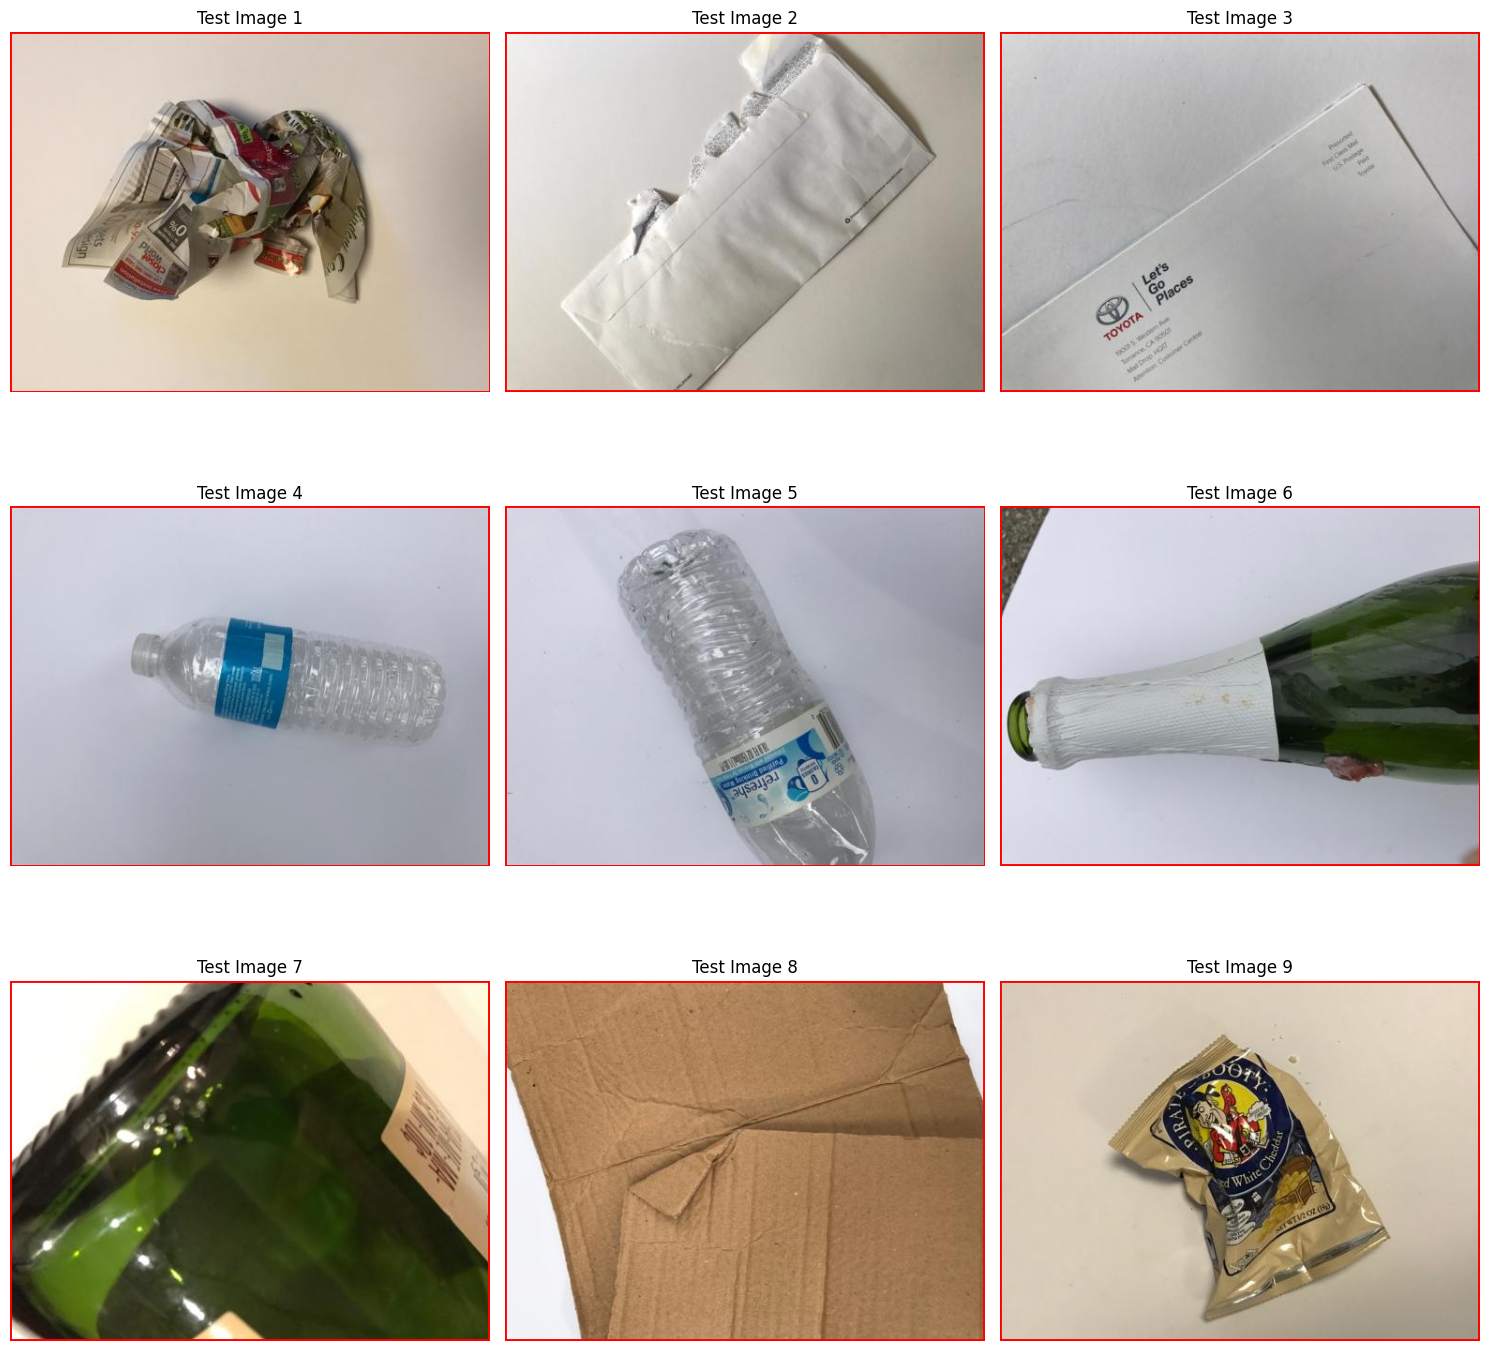


Model Status Check:
-------------------
Best model: 5.95MB (Created: Mon Jun 30 05:25:58 2025)
Last model: 5.95MB (Created: Mon Jun 30 05:25:58 2025)
Classes available: Yes
Number of classes: 6
Class names: paper, metal, cardboard, trash, glass, plastic
-------------------

-------------------
Garbage Classifier System Launcher
-------------------
Found trained garbage classification model.
Model: garbage_classification_yolo/models/garbage_classifier/weights/best.pt.
Size: 5.95 MB.
Loaded classes from 'dataset.yaml'.
Classes: 6 total
Class names: paper, metal, cardboard, trash, glass, plastic

-------------------
Inference Options:
1. Launch real-time inference with webcam
2. Test model on sample images
3. Exit

Testing model on sample images...
Found 257 test images.
Model loaded: garbage_classification_yolo/models/garbage_classifier/weights/best.pt.
Running inference on sample images...


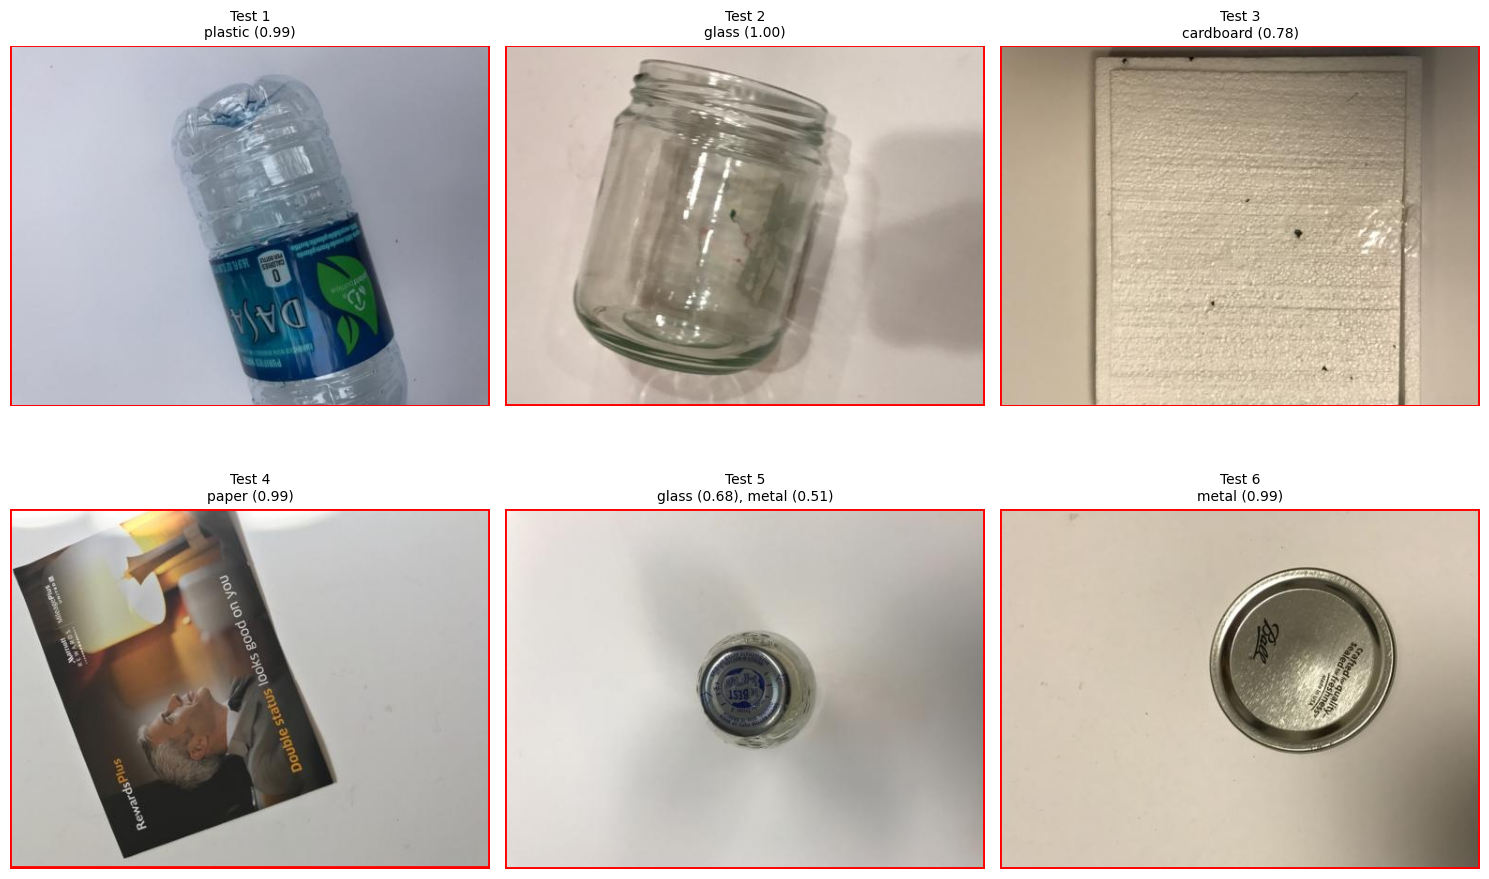

Sample testing completed.


In [2]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import yaml
from PIL import Image
import random
from pyngrok import ngrok
from sklearn.model_selection import train_test_split
import torch
import torchvision
from IPython.display import display, HTML
import qrcode
import threading
import time
from flask import Flask, render_template_string, jsonify, request
import socket
import random
import sys
from contextlib import redirect_stdout
import io
import warnings
warnings.filterwarnings('ignore')
os.environ['ULTRALYTICS_VERBOSE'] = 'False'
os.environ['YOLO_VERBOSE'] = 'False'
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using device: {device}.")
from ultralytics import YOLO
project_root = Path("garbage_classification_yolo")
project_root.mkdir(exist_ok=True)
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)
raw_data_dir = data_dir / "raw"
yolo_data_dir = data_dir / "yolo_format"
yolo_data_dir.mkdir(exist_ok=True)
for split in ['train', 'val', 'test']:
    (yolo_data_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (yolo_data_dir / split / 'labels').mkdir(parents=True, exist_ok=True)
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)
results_dir = project_root / "results"
results_dir.mkdir(exist_ok=True)
print("Project structure created.")
def explore_dataset(data_path):
    data_path = Path(data_path)    
    if not data_path.exists():
        print(f"Dataset path {data_path} does not exist.")
        return None, None    
    classes = []
    class_counts = {}
    for class_dir in data_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            classes.append(class_name)
            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpeg'))
            class_counts[class_name] = len(image_files)
    if not classes:
        print("No classes found in dataset directory.")
        return None, None
    print(f"Found {len(classes)} classes:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()    
    return classes, class_counts
classes, class_counts = explore_dataset(raw_data_dir)
def create_yolo_labels(data_path, classes, output_dir):
    data_path = Path(data_path)
    output_dir = Path(output_dir)
    if not classes:
        print("No classes provided. Cannot create labels.")
        return [], {}
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}    
    all_files = []
    labels_created = 0
    for class_dir in data_path.iterdir():
        if class_dir.is_dir() and class_dir.name in classes:
            class_name = class_dir.name
            class_id = class_to_id[class_name]
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
            image_files = []
            for ext in image_extensions:
                image_files.extend(list(class_dir.glob(ext)))            
            print(f"Processing {len(image_files)} images from class '{class_name}'.")
            for img_file in image_files:
                try:
                    img = cv2.imread(str(img_file))
                    if img is None:
                        continue                        
                    h, w = img.shape[:2]
                    yolo_label = f"{class_id} 0.5 0.5 1.0 1.0\n"                    
                    all_files.append({
                        'image_path': img_file, 'class_name': class_name,
                        'class_id': class_id, 'label_content': yolo_label.strip()})
                    labels_created += 1
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
    print(f"Created labels for {labels_created} images.")
    return all_files, class_to_id
if classes:
    all_files, class_to_id = create_yolo_labels(raw_data_dir, classes, yolo_data_dir)
    print(f"Total files processed: {len(all_files)}")
    print(f"Class mapping: {class_to_id}")
else:
    print("Please ensure the dataset is properly set up first.")
def split_dataset(all_files, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    class_files = {}
    for file_info in all_files:
        class_name = file_info['class_name']
        if class_name not in class_files:
            class_files[class_name] = []
        class_files[class_name].append(file_info)    
    train_files, val_files, test_files = [], [], []
    for class_name, files in class_files.items():
        random.shuffle(files)        
        n_files = len(files)
        n_train = int(n_files * train_ratio)
        n_val = int(n_files * val_ratio)
        train_files.extend(files[:n_train])
        val_files.extend(files[n_train:n_train + n_val])
        test_files.extend(files[n_train + n_val:])        
        print(f"Class {class_name}: {len(files[:n_train])} train, {len(files[n_train:n_train + n_val])} val, {len(files[n_train + n_val:])} test")
    return train_files, val_files, test_files
def copy_files_to_yolo_structure(file_list, split_name, yolo_data_dir):
    images_dir = yolo_data_dir / split_name / 'images'
    labels_dir = yolo_data_dir / split_name / 'labels'
    for i, file_info in enumerate(file_list):
        try:
            src_img = file_info['image_path']
            dst_img = images_dir / f"{split_name}_{i:06d}.jpg"            
            img = cv2.imread(str(src_img))
            cv2.imwrite(str(dst_img), img)            
            dst_label = labels_dir / f"{split_name}_{i:06d}.txt"
            with open(dst_label, 'w') as f:
                f.write(file_info['label_content'])
        except Exception as e:
            print(f"Error copying file {file_info['image_path']}: {e}.")
if 'all_files' in locals() and all_files:
    random.seed(42)    
    train_files, val_files, test_files = split_dataset(all_files)
    print(f"\nDataset split:")
    print(f"Train: {len(train_files)} images")
    print(f"Validation: {len(val_files)} images")
    print(f"Test: {len(test_files)} images")    
    copy_files_to_yolo_structure(train_files, 'train', yolo_data_dir)
    copy_files_to_yolo_structure(val_files, 'val', yolo_data_dir)
    copy_files_to_yolo_structure(test_files, 'test', yolo_data_dir)
    print("Dataset preparation completed.")
def create_yolo_config(classes, yolo_data_dir):    
    if not classes:
        print("No classes provided. Cannot create YOLO configuration.")
        return None
    config = {
        'path': str(yolo_data_dir.absolute()), 'train': 'train/images',
        'val': 'val/images', 'test': 'test/images',
        'nc': len(classes), 'names': classes}
    config_file = yolo_data_dir / 'dataset.yaml'
    with open(config_file, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"YOLO config created: {config_file}.")
    return config_file
if 'classes' in locals() and classes:
    config_file = create_yolo_config(classes, yolo_data_dir)
else:
    print("No classes defined.")
def visualize_samples(yolo_data_dir, classes, split='train', n_samples=6):    
    if not classes:
        print("No classes provided. Cannot visualize samples.")
        return
    images_dir = yolo_data_dir / split / 'images'
    labels_dir = yolo_data_dir / split / 'labels'
    image_files = list(images_dir.glob('*.jpg'))[:n_samples]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for i, img_file in enumerate(image_files):
        if i >= len(axes):
            break            
        img = cv2.imread(str(img_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_file = labels_dir / (img_file.stem + '.txt')
        if label_file.exists():
            with open(label_file, 'r') as f:
                label_line = f.readline().strip()            
            if label_line:
                parts = label_line.split()
                class_id = int(parts[0])
                class_name = classes[class_id]
                axes[i].imshow(img_rgb)
                axes[i].set_title(f'Class: {class_name}')
                axes[i].axis('off')
    plt.tight_layout()
    plt.show()
if 'classes' in locals() and classes:
    visualize_samples(yolo_data_dir, classes)
def check_existing_model(models_dir):
    best_model_path = models_dir / 'garbage_classifier' / 'weights' / 'best.pt'
    last_model_path = models_dir / 'garbage_classifier' / 'weights' / 'last.pt'    
    model_info = {
        'best_exists': best_model_path.exists(),
        'last_exists': last_model_path.exists(),
        'best_path': best_model_path,
        'last_path': last_model_path}
    if model_info['best_exists']:
        model_size = best_model_path.stat().st_size / (1024*1024) 
        model_time = time.ctime(best_model_path.stat().st_mtime)
        model_info['size_mb'] = model_size
        model_info['created_time'] = model_time
    return model_info
def display_model_options(model_info):
    print("\n" + "-------------------")
    print("Garbage Classifier System Options")
    print("-------------------")
    if model_info['best_exists']:
        print("Existing trained model found.")
        print(f"Path: {model_info['best_path']}")
        print(f"Size: {model_info['size_mb']:.2f} MB")
        print(f"Created: {model_info['created_time']}")
    else:
        print("No existing trained model found.")
    print("\nAvailable options:")
    print("1. Train new model from scratch")
    print("2. Load existing model (if available)")
    print("3. Continue training existing model")
    print("4. Skip training")
    print("-------------------")
def get_user_choice():
    while True:
        try:
            choice = input("\nEnter your choice (1-4): ").strip()
            if choice in ['1', '2', '3', '4']:
                return int(choice)
            else:
                print("Invalid choice. Please enter 1, 2, 3, or 4.")
        except KeyboardInterrupt:
            print("\nOperation cancelled.")
            return 4
        except:
            print("Invalid input. Please enter a number (1-4).")
def train_yolo_model(config_file, models_dir, device='mps', resume=False, existing_model_path=None):    
    if existing_model_path and existing_model_path.exists():
        print(f"Loading existing model: {existing_model_path}...")
        model = YOLO(str(existing_model_path))
    else:
        print("Loading pre-trained YOLOv8 model...")
        model = YOLO('yolov8n.pt') 
    train_params = {
        'data': str(config_file), 'epochs': 50,  
        'imgsz': 640, 'batch': 16, 'device': device,
        'project': str(models_dir), 'name': 'garbage_classifier',
        'save': True, 'plots': True, 'cache': True, 'workers': 4, 
        'patience': 10, 'save_period': 10, 'resume': resume}
    print("Starting training...")
    print(f"Training parameters: {train_params}")
    results = model.train(**train_params)
    return model, results
def load_existing_model(model_path):
    try:
        model = YOLO(str(model_path))
        print(f"Successfully loaded model: {model_path}.")
        print("\nModel Information:")
        print("-------------------")
        model.info(detailed=False)
        return model
    except Exception as e:
        print(f"Error loading model: {e}.")
        return None
if 'config_file' in locals() and config_file:
    model_info = check_existing_model(models_dir)
    display_model_options(model_info)    
    choice = get_user_choice()
    if choice == 1:
        print("\nTraining new model from scratch...")
        if model_info['best_exists']:
            backup_dir = models_dir / 'backups'
            backup_dir.mkdir(exist_ok=True)
            backup_path = backup_dir / f"backup_{int(time.time())}.pt"
            shutil.copy2(model_info['best_path'], backup_path)
            print(f"Existing model backed up to: {backup_path}.")
        model, training_results = train_yolo_model(config_file, models_dir, device)
        print("Training completed.")
        print(f"Best model saved at: '{models_dir}/garbage_classifier/weights/best.pt'.")
    elif choice == 2:
        if model_info['best_exists']:
            print("\nLoading existing model...")
            model = load_existing_model(model_info['best_path'])
            if model:
                print("Model loaded successfully.")
            else:
                print("Failed to load model. Please try training a new model.")
        else:
            print("No existing model found. Please train a new model first.")
            model = None
    elif choice == 3:
        if model_info['best_exists']:
            print("\nContinuing training from existing model...")
            model, training_results = train_yolo_model(
                config_file, models_dir, device, 
                resume=True, 
                existing_model_path=model_info['best_path'])
            print("Continued training completed.")
        else:
            print("No existing model found to continue training.")
            print("Starting fresh training...")
            model, training_results = train_yolo_model(config_file, models_dir, device)
    elif choice == 4:
        print("Skipping training. Loading existing model if available...")
        if model_info['best_exists']:
            model = load_existing_model(model_info['best_path'])
        else:
            print("No existing model found. You'll need to train a model first.")
            model = None
    print("\n" + ("-------------------"))
    if 'model' in locals() and model:
        print("Model is ready for use.")
        print(f"Model location: '{models_dir}/garbage_classifier/weights/best.pt'.")
    else:
        print("No model found.")
    print("-------------------")   
else:
    print("Configuration file not found.")
def manage_model_versions():
    models_base = models_dir / 'garbage_classifier'
    if not models_base.exists():
        print("No models directory found.")
        return    
    print("\nAvailable Model Versions:")
    print("-------------------")
    weights_dir = models_base / 'weights'
    if weights_dir.exists():
        for model_file in weights_dir.glob('*.pt'):
            size_mb = model_file.stat().st_size / (1024*1024)
            created = time.ctime(model_file.stat().st_mtime)
            print(f"{model_file.name} - {size_mb:.2f}MB - {created}")    
    backup_dir = models_dir / 'backups'
    if backup_dir.exists() and any(backup_dir.iterdir()):
        print("\nBackup Models:")
        print("-------------------")
        for backup_file in backup_dir.glob('*.pt'):
            size_mb = backup_file.stat().st_size / (1024*1024)
            created = time.ctime(backup_file.stat().st_mtime)
            print(f"{backup_file.name} - {size_mb:.2f}MB - {created}")
print("\nCurrent model status:")
if models_dir.exists():
    manage_model_versions()
else:
    print("Models directory not created yet.")
def evaluate_model(model_path, test_data_dir, classes):    
    if not classes:
        print("No classes provided. Cannot evaluate model.")
        return None
    model = YOLO(model_path)
    test_results = model.val(data=str(config_file), split='test', device=device, plots=True, save_json=True)
    return test_results
def show_test_predictions(model_path, test_images_dir, classes, n_samples=9):    
    if not classes:
        print("No classes provided. Cannot show test predictions.")
        return
    model = YOLO(model_path)
    test_images = list(Path(test_images_dir).glob('*.jpg'))[:n_samples]
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    for i, img_path in enumerate(test_images):
        if i >= len(axes):
            break
        results = model(str(img_path))
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls_id = int(box.cls[0].cpu().numpy())                
                cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)                
                label = f"{classes[cls_id]}: {conf:.2f}"
                cv2.putText(img_rgb, label, (int(x1), int(y1)-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'Test Image {i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
if 'model' in locals():
    best_model_path = models_dir / 'garbage_classifier' / 'weights' / 'best.pt'
    if best_model_path.exists():
        test_results = evaluate_model(best_model_path, yolo_data_dir / 'test' / 'images', classes)        
        show_test_predictions(best_model_path, yolo_data_dir / 'test' / 'images', classes)
class GarbageClassifierApp:
    def __init__(self, model_path, classes):
        self.model = YOLO(model_path)
        self.classes = classes
        self.app = Flask(__name__)
        self.is_running = False
        self.cap = None
        self.current_frame = None
        self.predictions = []
        self.setup_routes()
    def setup_routes(self):
        @self.app.route('/')
        def index():
            return render_template_string('''
                <!DOCTYPE html>
                <html>
                <head>
                    <title>Garbage Classifier</title>
                    <meta name="viewport" content="width=device-width, initial-scale=1">
                    <style>
                        body { 
                            font-family: Arial, sans-serif; 
                            text-align: center; 
                            padding: 20px; 
                            background-color: #f0f0f0;
                        }
                        .container { max-width: 400px; margin: 0 auto; }
                        button { 
                            font-size: 18px; 
                            padding: 15px 30px; 
                            margin: 10px; 
                            border: none; 
                            border-radius: 8px; 
                            cursor: pointer;
                            width: 100%;
                            max-width: 300px;
                        }
                        .capture { background-color: #2196F3; color: white; }
                        .stop { background-color: #f44336; color: white; }
                        .status { 
                            font-size: 18px; 
                            margin: 20px; 
                            padding: 15px;
                            background-color: white;
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                        .predictions { 
                            margin: 20px 0; 
                            padding: 15px; 
                            background-color: white; 
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                        .prediction-item {
                            background-color: #e8f4fd;
                            margin: 5px 0;
                            padding: 10px;
                            border-radius: 5px;
                            border-left: 4px solid #2196F3;
                        }
                        .upload-section {
                            margin: 20px 0;
                            padding: 20px;
                            background-color: white;
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                        .file-input-wrapper {
                            position: relative;
                            display: inline-block;
                            width: 100%;
                            max-width: 300px;
                        }
                        .file-input {
                            position: absolute;
                            left: -9999px;
                        }
                        .file-input-label {
                            display: block;
                            padding: 15px 30px;
                            background-color: #FF9800;
                            color: white;
                            border-radius: 8px;
                            cursor: pointer;
                            font-size: 18px;
                            transition: background-color 0.3s;
                        }
                        .file-input-label:hover {
                            background-color: #F57C00;
                        }
                        .preview-image {
                            max-width: 100%;
                            max-height: 300px;
                            margin: 10px 0;
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                        .video-section {
                            margin: 20px 0;
                            padding: 20px;
                            background-color: white;
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                        #videoFeed {
                            max-width: 100%;
                            max-height: 300px;
                            border-radius: 8px;
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                        }
                    </style>
                </head>
                <body>
                    <div class="container">
                        <h1>Garbage Classifier System</h1>
                        <div class="status" id="status">Status: Ready to process</div>
                        <div class="video-section">
                            <h3>Live Camera Feed</h3>
                            <video id="videoFeed" autoplay playsinline></video>
                            <button class="capture" id="startCameraBtn" onclick="startCamera()">Start Camera</button>
                            <button class="stop" id="stopCameraBtn" onclick="stopCamera()" style="display:none;">Stop Camera</button>
                        </div>
                        <div class="upload-section">
                            <h3>Upload Image</h3>
                            <div class="file-input-wrapper">
                                <input type="file" id="fileInput" class="file-input" accept="image/*" onchange="handleFileSelect(event)">
                                <label for="fileInput" class="file-input-label">Choose Image File</label>
                            </div>
                            <div id="imagePreview"></div>
                            <button class="capture" id="analyzeUploadBtn" onclick="analyzeUploadedImage()" style="display:none;">Analyze Uploaded Image</button>
                        </div>
                        <div class="predictions" id="predictions">
                            <h3>Analysis Results</h3>
                            <div id="prediction-list">No analysis yet</div>
                        </div>
                    </div>
                    <script>
                        let uploadedImageData = null;
                        let stream = null;
                        let video = null;
                        let captureInterval = null;
                        async function startCamera() {
                            try {
                                stream = await navigator.mediaDevices.getUserMedia({ video: true });
                                video = document.getElementById('videoFeed');
                                video.srcObject = stream;
                                document.getElementById('startCameraBtn').style.display = 'none';
                                document.getElementById('stopCameraBtn').style.display = 'inline-block';
                                document.getElementById('status').innerText = 'Status: Camera Started - Analyzing...';                                
                                captureInterval = setInterval(captureFrame, 1000); 
                            } catch (error) {
                                console.error('Error accessing camera:', error);
                                document.getElementById('status').innerText = 'Status: Error accessing camera';
                                alert('Could not access camera. Please ensure permissions are granted.');
                            }
                        }
                        async function stopCamera() {
                            if (stream) {
                                stream.getTracks().forEach(track => track.stop());
                                stream = null;
                            }
                            if (video) {
                                video.srcObject = null;
                            }
                            if (captureInterval) {
                                clearInterval(captureInterval);
                                captureInterval = null;
                            }
                            document.getElementById('startCameraBtn').style.display = 'inline-block';
                            document.getElementById('stopCameraBtn').style.display = 'none';
                            document.getElementById('status').innerText = 'Status: Camera Stopped';
                            document.getElementById('prediction-list').innerHTML = 'No analysis yet';
                        }
                        async function captureFrame() {
                            if (!video || !stream) return;
                            const canvas = document.createElement('canvas');
                            canvas.width = video.videoWidth;
                            canvas.height = video.videoHeight;
                            canvas.getContext('2d').drawImage(video, 0, 0, canvas.width, canvas.height);
                            const blob = await new Promise(resolve => canvas.toBlob(resolve, 'image/jpeg'));
                            await analyzeImage(blob);
                        }
                        function handleFileSelect(event) {
                            const file = event.target.files[0];
                            if (!file) return;
                            if (!file.type.startsWith('image/')) {
                                alert('Please select an image file');
                                return;
                            }
                            const reader = new FileReader();
                            reader.onload = function(e) {
                                uploadedImageData = e.target.result;
                                const preview = document.getElementById('imagePreview');
                                preview.innerHTML = `<img src="${uploadedImageData}" class="preview-image" alt="Selected image">`;
                                document.getElementById('analyzeUploadBtn').style.display = 'inline-block';
                                document.getElementById('status').innerText = 'Status: Image uploaded - Click Analyze to classify';
                            };
                            reader.readAsDataURL(file);
                        }
                        async function analyzeUploadedImage() {
                            if (!uploadedImageData) {
                                alert('Please select an image first');
                                return;
                            }   
                            const response = await fetch(uploadedImageData);
                            const blob = await response.blob();
                            await analyzeImage(blob);
                        }
                        async function analyzeImage(blob) {
                            const formData = new FormData();
                            formData.append('image', blob, 'capture.jpg');
                            document.getElementById('status').innerText = 'Status: Analyzing...';
                            try {
                                const response = await fetch('/analyze', {
                                    method: 'POST',
                                    body: formData
                                });
                                const result = await response.json();
                                displayResults(result);
                                document.getElementById('status').innerText = 'Status: Analysis Completed.';
                            } catch (error) {
                                console.error('Error:', error);
                                document.getElementById('status').innerText = 'Status: Analysis Failed.';
                                alert('Analysis failed. Please try again.');
                            }
                        }
                        function displayResults(result) {
                            const predList = document.getElementById('prediction-list');
                            if (result.predictions && result.predictions.length > 0) {
                                predList.innerHTML = result.predictions
                                    .map(pred => `
                                        <div class="prediction-item">
                                            <strong>${pred.class}</strong><br>
                                            Confidence: ${pred.confidence}%
                                        </div>
                                    `).join('');
                            } else {
                                predList.innerHTML = '<div class="prediction-item">No garbage detected in image</div>';
                            }
                        }
                    </script>
                </body>
                </html>
            ''')
        @self.app.route('/start', methods=['POST'])
        def start():
            if not self.is_running:
                self.cap = cv2.VideoCapture(0)
                if not self.cap.isOpened():
                    return jsonify({'status': 'Error: Could not open camera'})
                self.is_running = True
                return jsonify({'status': 'Camera Started'})
            return jsonify({'status': 'Camera Already Running'})
        @self.app.route('/stop', methods=['POST'])
        def stop():
            if self.is_running:
                self.is_running = False
                if self.cap:
                    self.cap.release()
                    self.cap = None
                self.predictions = []
                return jsonify({'status': 'Camera Stopped'})
            return jsonify({'status': 'Camera Already Stopped'})
        @self.app.route('/predictions', methods=['GET'])
        def get_predictions():
            return jsonify({'predictions': self.predictions})
        @self.app.route('/analyze', methods=['POST'])
        def analyze():
            if 'image' not in request.files:
                return jsonify({'error': 'No image provided'}), 400
            image_file = request.files['image']
            image = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_COLOR)
            results = self.model.predict(image)
            predictions = []
            for result in results:
                for box in result.boxes:
                    class_id = int(box.cls)
                    confidence = float(box.conf) * 100
                    if class_id < len(self.classes):
                        predictions.append({
                            'class': self.classes[class_id],
                            'confidence': round(confidence, 2)})
            self.predictions = predictions
            return jsonify({'predictions': predictions})
    def start_inference(self):
        self.is_running = True
        self.cap = cv2.VideoCapture(0)
        inference_thread = threading.Thread(target=self.inference_loop)
        inference_thread.daemon = True
        inference_thread.start()    
    def stop_inference(self):
        self.is_running = False
        if self.cap:
            self.cap.release()
        cv2.destroyAllWindows()
    def inference_loop(self):
        while self.is_running and self.cap and self.cap.isOpened():
            ret, frame = self.cap.read()
            if not ret:
                break            
            results = self.model(frame)
            current_predictions = []
            annotated_frame = frame.copy()            
            if len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls_id = int(box.cls[0].cpu().numpy())                    
                    if conf > 0.5: 
                        class_name = self.classes[cls_id] if cls_id < len(self.classes) else f"Unknown_{cls_id}"
                        confidence = f"{conf*100:.1f}"
                        cv2.rectangle(annotated_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)                        
                        label = f"{class_name}: {confidence}%"
                        cv2.putText(annotated_frame, label, (int(x1), int(y1)-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)                        
                        current_predictions.append({
                            'class': class_name,
                            'confidence': confidence})
            if current_predictions:
                self.predictions.extend(current_predictions)
                self.predictions = self.predictions[-20:]            
            cv2.imshow('Garbage Classifier', annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        self.stop_inference()
    def get_local_ip(self):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            s.connect(("8.8.8.8", 80))
            ip = s.getsockname()[0]
            s.close()
            return ip
        except:
            return "127.0.0.1"    
    def generate_qr_code(self, port=5001):
        local_ip = self.get_local_ip()
        url = f"http://{local_ip}:{port}/"        
        qr = qrcode.QRCode(version=1, box_size=10, border=5)
        qr.add_data(url)
        qr.make(fit=True)
        qr_img = qr.make_image(fill_color="black", back_color="white")
        qr_img.save("garbage_classifier_qr.png")
        return url, "garbage_classifier_qr.png"
    def run(self, port=5000, debug=False):
        url, qr_path = self.generate_qr_code(port)
        print(f"Garbage Classifier System Server Starting...")
        print(f"Access URL: {url}")
        print(f"QR Code saved as: {qr_path}")
        print(f"Scan the QR code with your smartphone.")
        try:
            from IPython.display import Image as IPImage
            display(IPImage(qr_path))
        except:
            print("QR code saved as 'garbage_classifier_qr.png'.")
        self.app.run(host='0.0.0.0', port=port, debug=debug)
def load_classes_from_yaml(config_file):
    try:
        with open(config_file, 'r') as f:
            config = yaml.safe_load(f)
            return config.get('names', [])
    except Exception as e:
        print(f"Error loading classes from {config_file}: {e}.")
        return None
def launch_garbage_classifier():    
    print("\n" + "-------------------")
    print("Garbage Classifier System Launcher")
    print("-------------------")
    best_model_path = models_dir / 'garbage_classifier' / 'weights' / 'best.pt'
    last_model_path = models_dir / 'garbage_classifier' / 'weights' / 'last.pt'    
    model_path = None
    demo_classes = None
    if best_model_path.exists():
        model_path = best_model_path
        print("Found trained garbage classification model.")
        print(f"Model: {model_path}.")
        model_size = model_path.stat().st_size / (1024*1024)
        print(f"Size: {model_size:.2f} MB.")
    elif last_model_path.exists():
        model_path = last_model_path
        print("Found last checkpoint model (best model not available).")
        print(f"Model: {model_path}.")
        print("Consider training for more epochs to get a better model.")
    else:
        print("No trained garbage classification model found.")
        return    
    if 'classes' in locals() and classes:
        demo_classes = classes
        print("Using classes from dataset exploration...")
    else:
        config_file_path = yolo_data_dir / 'dataset.yaml'
        if config_file_path.exists():
            demo_classes = load_classes_from_yaml(config_file_path)
            if demo_classes:
                print("Loaded classes from 'dataset.yaml'.")
            else:
                print("Failed to load classes from 'dataset.yaml'.")
                return
        else:
            print("'dataset.yaml' not found.")
            return
    print(f"Classes: {len(demo_classes)} total")
    print(f"Class names: {', '.join(demo_classes)}")
    print("\n" + "-------------------")
    print("Inference Options:")
    print("1. Launch real-time inference with webcam")
    print("2. Test model on sample images")
    print("3. Exit")
    try:
        choice = input("\nEnter your choice (1-3): ").strip()
        if choice == '1':
            print("\nLaunching real-time inference...")
            app = GarbageClassifierApp(model_path, demo_classes)
            print("\n" + "-------------------")
            print("Garbage Classifier System Ready...")
            print("-------------------")            
            try:
                app.run(port=5001)
            except KeyboardInterrupt:
                print("\nServer stopped.")
            except Exception as e:
                print(f"\nError running server: {e}.")
        elif choice == '2':
            print("\nTesting model on sample images...")
            test_model_on_samples(model_path, demo_classes)
        elif choice == '3':
            print("The system ends.")
            return
        else:
            print("Invalid choice. Please run again.")
    except KeyboardInterrupt:
        print("\nOperation cancelled by user.")
    except Exception as e:
        print(f"\nError: {e}.")
def test_model_on_samples(model_path, classes):
    if not classes:
        print("No classes provided. Cannot test model.")
        return
    test_images_dir = yolo_data_dir / 'test' / 'images'
    if not test_images_dir.exists():
        print("Test images directory not found.")
        return    
    test_images = list(test_images_dir.glob('*.jpg'))
    if not test_images:
        print("No test images found.")
        return
    print(f"Found {len(test_images)} test images.")
    try:
        model = YOLO(model_path)
        print(f"Model loaded: {model_path}.")
    except Exception as e:
        print(f"Error loading model: {e}.")
        return    
    random.seed()  
    sample_images = random.sample(test_images, min(6, len(test_images)))    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    print("Running inference on sample images...")
    for i, img_path in enumerate(sample_images):
        if i >= len(axes):
            break
        try:
            results = model(str(img_path))            
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            predictions_text = []
            if len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls_id = int(box.cls[0].cpu().numpy())                    
                    if conf > 0.3: 
                        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)                        
                        class_name = classes[cls_id] if cls_id < len(classes) else f"Class_{cls_id}"
                        label = f"{class_name}: {conf:.2f}"
                        cv2.putText(img_rgb, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)                        
                        predictions_text.append(f"{class_name} ({conf:.2f})")
            axes[i].imshow(img_rgb)
            title = f"Test {i+1}"
            if predictions_text:
                title += f"\n{', '.join(predictions_text[:2])}"
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error processing {img_path}: {e}.")
            axes[i].text(0.5, 0.5, f"Error\nprocessing\nimage", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print("Sample testing completed.")
def check_model_status():    
    print("\nModel Status Check:")
    print("-------------------")
    models_found = []    
    best_model_path = models_dir / 'garbage_classifier' / 'weights' / 'best.pt'
    if best_model_path.exists():
        size_mb = best_model_path.stat().st_size / (1024*1024)
        created = time.ctime(best_model_path.stat().st_mtime)
        models_found.append(f"Best model: {size_mb:.2f}MB (Created: {created})")    
    last_model_path = models_dir / 'garbage_classifier' / 'weights' / 'last.pt'
    if last_model_path.exists():
        size_mb = last_model_path.stat().st_size / (1024*1024)
        created = time.ctime(last_model_path.stat().st_mtime)
        models_found.append(f"Last model: {size_mb:.2f}MB (Created: {created})")    
    classes_available = False
    class_count = 0
    class_names = []
    if 'classes' in locals() and classes:
        classes_available = True
        class_count = len(classes)
        class_names = classes
    else:
        config_file_path = yolo_data_dir / 'dataset.yaml'
        if config_file_path.exists():
            loaded_classes = load_classes_from_yaml(config_file_path)
            if loaded_classes:
                classes_available = True
                class_count = len(loaded_classes)
                class_names = loaded_classes
    if models_found:
        for model_info in models_found:
            print(model_info)
        print(f"Classes available: {'Yes' if classes_available else 'No'}")
        if classes_available:
            print(f"Number of classes: {class_count}")
            print(f"Class names: {', '.join(class_names)}")
    else:
        print("No trained models found.")    
    print("-------------------")
check_model_status()
launch_garbage_classifier()
def export_model_for_mobile(model_path, export_format='onnx'):
    model = YOLO(model_path)    
    if export_format == 'onnx':
        model.export(format='onnx', dynamic=True, simplify=True)
    elif export_format == 'coreml':
        model.export(format='coreml')
    elif export_format == 'tflite':
        model.export(format='tflite')
    print(f"Model exported in {export_format} format.")
def create_model_summary():
    best_model_path = models_dir / 'garbage_classifier' / 'weights' / 'best.pt'    
    if best_model_path.exists():
        model = YOLO(best_model_path)
        if 'classes' not in locals() or not classes:
            config_file_path = yolo_data_dir / 'dataset.yaml'
            if config_file_path.exists():
                classes_to_use = load_classes_from_yaml(config_file_path)
            else:
                classes_to_use = []
        else:
            classes_to_use = classes        
        print("Model Summary")
        print("-------------------")
        print(f"Model Path: {best_model_path}")
        print(f"Model Size: {best_model_path.stat().st_size / (1024*1024):.2f} MB")
        print(f"Classes: {len(classes_to_use)}")
        print(f"Class Names: {', '.join(classes_to_use) if classes_to_use else 'Not available'}")        
        model.info(detailed=True)
        return model
    else:
        print("No trained model found.")
        return None
def batch_inference_on_folder(model_path, folder_path, output_folder):
    model = YOLO(model_path)    
    if 'classes' not in locals() or not classes:
        config_file_path = yolo_data_dir / 'dataset.yaml'
        if config_file_path.exists():
            classes_to_use = load_classes_from_yaml(config_file_path)
        else:
            print("No classes available.")
            return []
    else:
        classes_to_use = classes
    folder_path = Path(folder_path)
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True)
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    all_images = []
    for ext in image_extensions:
        all_images.extend(list(folder_path.glob(ext)))
    print(f"Processing {len(all_images)} images...")
    results_summary = []
    for img_path in all_images:
        results = model(str(img_path))        
        img = cv2.imread(str(img_path))
        predictions = []
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls_id = int(box.cls[0].cpu().numpy())
                if conf > 0.5: 
                    class_name = classes_to_use[cls_id] if cls_id < len(classes_to_use) else f"Unknown_{cls_id}"
                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)                    
                    label = f"{class_name}: {conf:.2f}"
                    cv2.putText(img, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    predictions.append({
                        'class': class_name,
                        'confidence': conf,
                        'bbox': [int(x1), int(y1), int(x2), int(y2)]})
        output_path = output_folder / f"annotated_{img_path.name}"
        cv2.imwrite(str(output_path), img)        
        results_summary.append({
            'image': img_path.name,
            'predictions': predictions,
            'output_path': str(output_path)})
    summary_file = output_folder / 'inference_results.json'
    with open(summary_file, 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)
    print(f"Batch inference completed.")
    print(f"Annotated images saved to: '{output_folder}'.")
    print(f"Results summary saved to: '{summary_file}'.")
    return results_summary
def analyze_training_results(results_dir):    
    results_path = Path(results_dir) / 'garbage_classifier'
    if not results_path.exists():
        print("Training results not found.")
        return
    results_csv = results_path / 'results.csv'
    if results_csv.exists():
        df = pd.read_csv(results_csv)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))        
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
        axes[0, 0].set_title('Box Loss Over Time')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', color='blue')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', color='red')
        axes[0, 1].set_title('Classification Loss Over Time')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)        
        if 'metrics/precision(B)' in df.columns:
            axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='green')
            axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='orange')
            axes[1, 0].set_title('Precision & Recall Over Time')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Score')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
            axes[1, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='purple')
            axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='brown')
            axes[1, 1].set_title('mAP Over Time')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('mAP')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        plt.tight_layout()
        plt.show()        
        final_epoch = df.iloc[-1]
        print("\nFinal Training Metrics:")
        print("-------------------")
        print(f"Final Epoch: {int(final_epoch['epoch'])}")
        print(f"Train Box Loss: {final_epoch['train/box_loss']:.4f}")
        print(f"Val Box Loss: {final_epoch['val/box_loss']:.4f}")
        print(f"Train Class Loss: {final_epoch['train/cls_loss']:.4f}")
        print(f"Val Class Loss: {final_epoch['val/cls_loss']:.4f}")
        if 'metrics/precision(B)' in df.columns:
            print(f"Precision: {final_epoch['metrics/precision(B)']:.4f}")
            print(f"Recall: {final_epoch['metrics/recall(B)']:.4f}")
            print(f"mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
            print(f"mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")
    else:
        print("Results CSV file not found.")
class AdvancedGarbageClassifier:    
    def __init__(self, model_path, classes):
        self.model = YOLO(model_path)
        self.classes = classes
        self.prediction_history = []
        self.confidence_threshold = 0.5
    def classify_with_confidence_analysis(self, image_path):        
        results = self.model(image_path)
        analysis = {
            'image_path': image_path, 'predictions': [],
            'confidence_stats': {}, 'timestamp': time.time()}
        confidences = []
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                conf = box.conf[0].cpu().numpy()
                cls_id = int(box.cls[0].cpu().numpy())
                if conf > self.confidence_threshold:
                    prediction = {
                        'class': self.classes[cls_id] if cls_id < len(self.classes) else f"Unknown_{cls_id}",
                        'confidence': float(conf),
                        'bbox': box.xyxy[0].cpu().numpy().tolist()}
                    analysis['predictions'].append(prediction)
                    confidences.append(conf)
        if confidences:
            analysis['confidence_stats'] = {
                'mean': float(np.mean(confidences)),
                'std': float(np.std(confidences)),
                'min': float(np.min(confidences)),
                'max': float(np.max(confidences)),
                'count': len(confidences)}
        self.prediction_history.append(analysis)
        return analysis
    def get_class_distribution(self, recent_n=100):        
        recent_predictions = self.prediction_history[-recent_n:]
        class_counts = {}
        for pred_session in recent_predictions:
            for pred in pred_session['predictions']:
                class_name = pred['class']
                class_counts[class_name] = class_counts.get(class_name, 0) + 1
        return class_counts
    def generate_insights_report(self):        
        if not self.prediction_history:
            return "No predictions available for analysis."
        total_sessions = len(self.prediction_history)
        total_predictions = sum(len(session['predictions']) for session in self.prediction_history)
        class_dist = self.get_class_distribution()
        most_common = max(class_dist.items(), key=lambda x: x[1]) if class_dist else None        
        all_confidences = []
        for session in self.prediction_history:
            for pred in session['predictions']:
                all_confidences.append(pred['confidence'])
        report = f"""
        Garbage Classification Insights Report
        -------------------
        
        Overall Statistics:
        - Total Classification Sessions: {total_sessions}
        - Total Objects Detected: {total_predictions}
        - Average Objects per Session: {total_predictions/total_sessions:.2f}
        
        Class Distribution:
        """
        
        for class_name, count in sorted(class_dist.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_predictions) * 100 if total_predictions > 0 else 0
            report += f"\n        - {class_name}: {count} ({percentage:.1f}%)"
        
        if most_common:
            report += f"\n        - Most Common Class: {most_common[0]} ({most_common[1]} detections)"
        
        if all_confidences:
            report += f"""
        
        Confidence Analysis:
        - Average Confidence: {np.mean(all_confidences):.3f}
        - Confidence Std Dev: {np.std(all_confidences):.3f}
        - Highest Confidence: {np.max(all_confidences):.3f}
        - Lowest Confidence: {np.min(all_confidences):.3f}
        """
        return report
def compare_yolo_models(config_file, models_to_compare=['yolov8n', 'yolov8s', 'yolov8m']):    
    comparison_results = {}
    for model_name in models_to_compare:
        print(f"\nTraining {model_name}...")
        model = YOLO(f'{model_name}.pt')
        results = model.train(
            data=str(config_file),
            epochs=10, 
            imgsz=640,
            batch=8,
            device=device,
            project=str(models_dir),
            name=f'comparison_{model_name}',
            save=True,
            plots=False,
            cache=True,
            verbose=False)        
        comparison_results[model_name] = {
            'final_loss': results.results_dict.get('val/box_loss', 0),
            'map50': results.results_dict.get('metrics/mAP50(B)', 0),
            'map50_95': results.results_dict.get('metrics/mAP50-95(B)', 0),
            'model_size': f"{model_name}.pt"}
    models = list(comparison_results.keys())
    map50_scores = [comparison_results[m]['map50'] for m in models]
    map50_95_scores = [comparison_results[m]['map50_95'] for m in models]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))    
    ax1.bar(models, map50_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
    ax1.set_title('mAP@0.5 Comparison')
    ax1.set_ylabel('mAP@0.5')
    ax1.set_ylim(0, 1)    
    ax2.bar(models, map50_95_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
    ax2.set_title('mAP@0.5:0.95 Comparison')
    ax2.set_ylabel('mAP@0.5:0.95')
    ax2.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()    
    print("\nModel Comparison Results:")
    print("-------------------")
    print(f"{'Model':<15} {'mAP@0.5':<10} {'mAP@0.5:0.95':<12} {'Val Loss':<10}")
    print("-------------------")
    for model_name, results in comparison_results.items():
        print(f"{model_name:<15} {results['map50']:<10.3f} {results['map50_95']:<12.3f} {results['final_loss']:<10.3f}")
    return comparison_results